In [1]:
import os
import numpy as np
import supervision as sv
import ultralytics
from ultralytics import YOLO
from IPython import display

### Install YOLOv8

In [2]:
display.clear_output()

ultralytics.checks()

Ultralytics 8.3.19  Python-3.10.16 torch-2.7.0+cpu CPU (13th Gen Intel Core(TM) i7-13700H)
Setup complete  (20 CPUs, 13.7 GB RAM, 143.7/221.0 GB disk)


### Install Roboflow Supervision 

In [3]:
display.clear_output()

print("Supervision.__version__: ", sv.__version__)

Supervision.__version__:  0.24.0


### Download example video

In [4]:
import gdown

file_id = "1TCXHKBRSqdsgn9QySEdlT5OLYNqjMwVL"

url = f"https://drive.google.com/uc?id={file_id}"

output = "vehicle-counting.mp4"

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1TCXHKBRSqdsgn9QySEdlT5OLYNqjMwVL
To: d:\Vehicle counting YOLOv8 with ByteTrack and DeepSORT\vehicle-counting.mp4
100%|██████████| 35.3M/35.3M [00:07<00:00, 4.93MB/s]


'vehicle-counting.mp4'

In [5]:
HOME = os.getcwd()

SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"

### Load pre-trained YOLO model

In [6]:
model = YOLO("yolov10x.pt")

### Predict and annotate single frame

In [7]:
CLASS_NAMES_DICT = model.model.names

SELECTED_CLASS_NAMES = ['car', 'motorcycle', 'bus', 'truck']

SELECTED_CLASS_IDS = [
    {value: key for key, value in CLASS_NAMES_DICT.items()}[class_name]
    for class_name
    in SELECTED_CLASS_NAMES
]

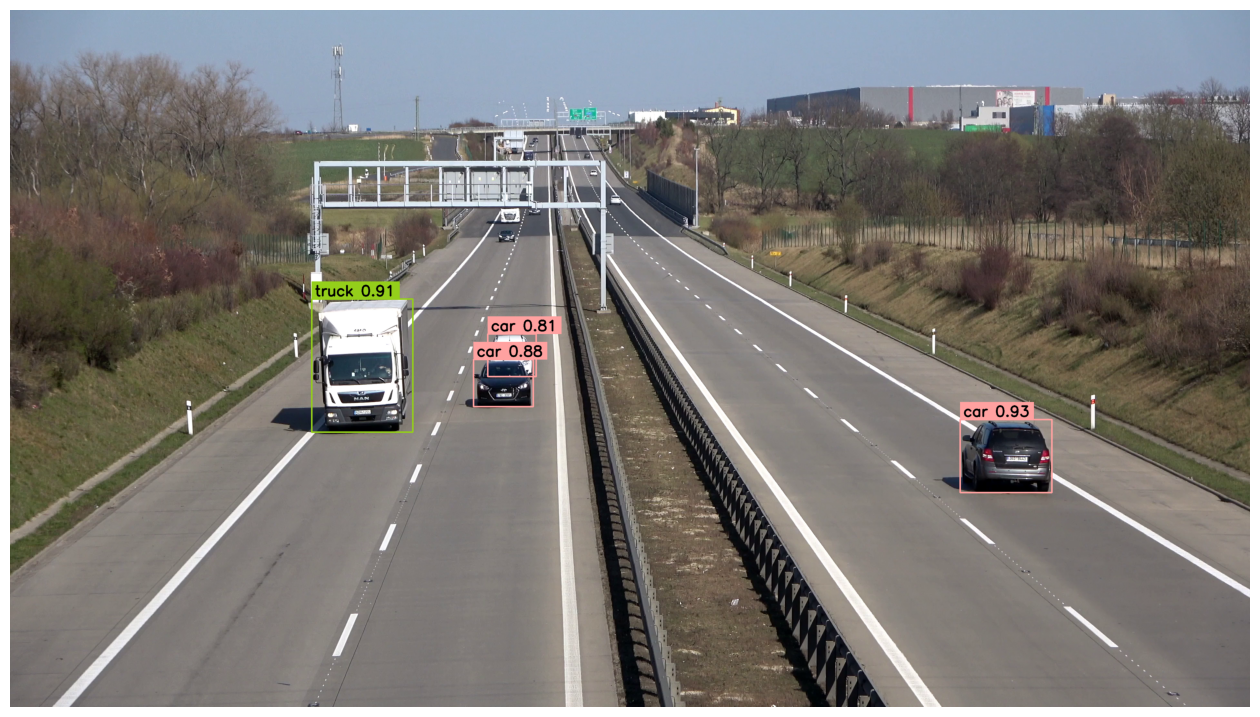

In [8]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(
    text_thickness=4, 
    text_scale=1.5, 
    text_color=sv.Color.BLACK 
)

iterator = iter(generator)
frame = next(iterator)

results = model(frame, verbose=False)[0]

detections = sv.Detections.from_ultralytics(results)

detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

labels = [ 
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}" 
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate( 
    scene=annotated_frame,
    detections=detections
)

annotated_frame = label_annotator.annotate( 
    scene=annotated_frame, 
    detections=detections, 
    labels=labels
)

%matplotlib inline 
sv.plot_image(annotated_frame, (16, 16))

In [9]:
print("Selected Class IDs: ", SELECTED_CLASS_IDS)
print("Detected Class IDs Before Filtering: ", detections.class_id)
detections = detections[np.isin(detections.class_id.astype(int), np.array(SELECTED_CLASS_IDS, dtype=int))]
print("Detected Class IDs After Filtering: ", detections.class_id)

Selected Class IDs:  [2, 3, 5, 7]
Detected Class IDs Before Filtering:  [2 7 2 2]
Detected Class IDs After Filtering:  [2 7 2 2]


### Predict and annotate whole video

In [10]:
LINE_START = sv.Point(0 + 50, 1500)
LINE_END = sv.Point(3840 - 50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/result_BYTETracker.mp4"

In [11]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

In [12]:
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3
)

byte_tracker.reset()


video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)


line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(
    text_thickness=2,
    text_scale=1.5, 
    text_color=sv.Color.BLACK
)

trace_annotator = sv.TraceAnnotator(
    thickness=4,
    trace_length=50
)

line_zone_annotator = sv.LineZoneAnnotator(
    thickness=4,
    text_thickness=4,
    text_scale=2
)

def callback(frame: np.ndarray, index: int) -> np.ndarray:
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[np.isin(detections.class_id.astype(int), np.array(SELECTED_CLASS_IDS, dtype=int))]
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]
    annotated_frame = frame.copy()

    annotated_frame = trace_annotator.annotate(
        scene=annotated_frame,
        detections=detections
    )

    annotated_frame = box_annotator.annotate(
        scene=annotated_frame,
        detections=detections
    )

    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels
    )

    line_zone.trigger(detections)

    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)

In [13]:
import subprocess
import imageio_ffmpeg as ffmpeg

input_file = "result_BYTETracker.mp4"
output_file = "output_video_ByteTrack.mp4"

ffmpeg_path = ffmpeg.get_ffmpeg_exe()

cmd = [
    ffmpeg_path,
    "-i", input_file,
    "-c:v", "libx264",
    "-preset", "fast",
    "-crf", "23",
    "-c:a", "aac",
    output_file
]

subprocess.run(cmd, check=True)

CompletedProcess(args=['c:\\Users\\AMIN\\anaconda3\\envs\\YOLO_Counting\\lib\\site-packages\\imageio_ffmpeg\\binaries\\ffmpeg-win-x86_64-v7.1.exe', '-i', 'result_BYTETracker.mp4', '-c:v', 'libx264', '-preset', 'fast', '-crf', '23', '-c:a', 'aac', 'output_video_ByteTrack.mp4'], returncode=0)

In [14]:
from IPython.display import Video, display

video = Video("output_video_ByteTrack.mp4", width=800)
display(video)